## DSCI 552 PS 1 - Used Car Dataset

In [46]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [38]:
df = pd.read_csv(r'data/used_car_dataset.csv')
print(df.shape)

(9997, 14)


In [39]:
df.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,type,paint_color,F1,F2,F3,F4
0,21978.0,2016.0,ford,like new,6 cylinders,gas,80813.0,automatic,SUV,black,138,2.472286,0.059031,b
1,4185.0,2008.0,ford,good,8 cylinders,gas,201800.0,automatic,SUV,white,415,2.285245,0.046328,c
2,7693.0,2002.0,ford,excellent,6 cylinders,gas,145000.0,automatic,pickup,white,535,1.861461,0.158554,b
3,15778.0,2016.0,ford,excellent,4 cylinders,gas,50103.0,automatic,sedan,white,3435,2.331671,0.213665,c
4,10520.0,2005.0,ford,good,8 cylinders,gas,207663.0,automatic,truck,white,1212,2.061082,0.388724,b


In [40]:
## Counts for cat vars
# df['manufacturer'].value_counts()
# df['condition'].value_counts()
# df['cylinders'].value_counts()
# df['fuel'].value_counts()
# df['transmission'].value_counts()
# df['type'].value_counts()
# df['paint_color'].value_counts()
# df['F4'].value_counts()

In [41]:
df.describe()

,price,year,odometer,F1,F2,F3
count,9997.000000,9997.000000,9.305000e+03,9997.000000,9997.000000,9997.000000
mean,14233.961989,2009.817345,1.139147e+05,1534.257377,2.224515,0.100247
std,12595.955311,8.847370,1.306907e+05,2138.048191,0.226997,0.100804
min,0.000000,1922.000000,0.000000e+00,4.000000,0.167352,-0.313948
25%,5594.000000,2007.000000,6.702100e+04,308.000000,2.131407,0.030308
50%,10333.000000,2012.000000,1.110000e+05,698.000000,2.255297,0.101295
75%,19389.000000,2015.000000,1.512140e+05,2013.000000,2.361656,0.167654
max,402498.000000,2021.000000,9.999999e+06,36773.000000,2.728576,0.526848


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         9997 non-null   float64
 1   year          9997 non-null   float64
 2   manufacturer  9997 non-null   object 
 3   condition     9997 non-null   object 
 4   cylinders     9997 non-null   object 
 5   fuel          9997 non-null   object 
 6   odometer      9305 non-null   float64
 7   transmission  9997 non-null   object 
 8   type          9997 non-null   object 
 9   paint_color   9997 non-null   object 
 10  F1            9997 non-null   int64  
 11  F2            9997 non-null   float64
 12  F3            9997 non-null   float64
 13  F4            9997 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 1.1+ MB


# EDA / cleaning / transforming step
Your CEO said: “The dataset describes conditions of various used cars and their current prices.
I would like to learn **what drives prices of used cars**. 

1. Look at the dataset and find the **main factors**
that affect the **value** of a car – and then explain it to me. 

2. Additionally, assess the **impact** of some special modifications (denoted by **F1, F2, F3 and F4** in your dataset) on the price. This would help us to understand, **if we should make the modifications before selling a car or not**. I would
like to see the report, describing your main findings, on my desk, on Thursday, February 11,
2021 at 10 A.M. “

Hint: You are asked to **find general trends** in the data. Report whatever you think is the most important. Your CEO
doesn’t want to see a list that is 20-times long. She would like to learn just about some general trends. To give you
an example, one general trend could be “The price decrease with the age of the car. Holding all other factors
constant, with each year, the price of a car decreases by \$570. However, these dynamics are not constant. Value of
younger cars decreases faster than the value of an old car. For example, the value of cars that are less than 5 years
old, decreases nearly $2,500 per year.” (This is just an example; your numbers might be different). Your second
task you have to check both, the **impact** and the **statistical significance** of the **F1-F4 attributes** for making the price predictions.



In [43]:
df.isnull().sum()  ## check for missing vals
# ## fill in missing values with mean imputation
# df['odometer'].fillna(df['odometer'].mean(), inplace=True)
# df.isnull().sum()  ## check for missing vals

price             0
year              0
manufacturer      0
condition         0
cylinders         0
fuel              0
odometer        692
transmission      0
type              0
paint_color       0
F1                0
F2                0
F3                0
F4                0
dtype: int64

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'odometer'}>,
        <AxesSubplot:title={'center':'F1'}>],
       [<AxesSubplot:title={'center':'F2'}>,
        <AxesSubplot:title={'center':'F3'}>]], dtype=object)

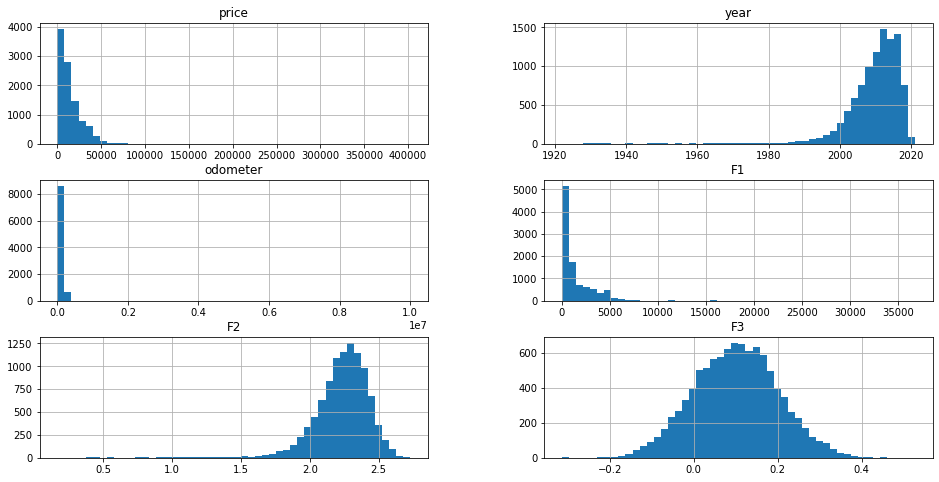

In [44]:
## plot data
df.hist(bins=50, figsize=(16,8))

In [45]:
## Due to skewed datasets, we should clean data by:
## remove outliers and fill missing vals (median imputation)
## and scale the datasets (minmaxscaler)
## and one-hot encoding for categorical vars (to prep for model)

data_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
    ## TODO
])

df_cleaned = data_pipeline.fit_transform(df)

ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: 'ford'

<AxesSubplot:>

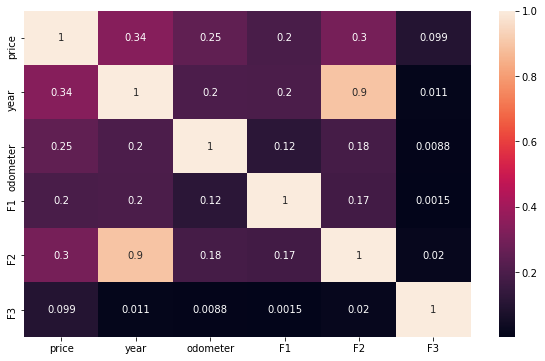

In [15]:
## View correlations btwn features
## focus on effect on PRICE
plt.figure(figsize=(10,6))
sns.heatmap(df.corr().abs(), annot=True)

<AxesSubplot:ylabel='price'>

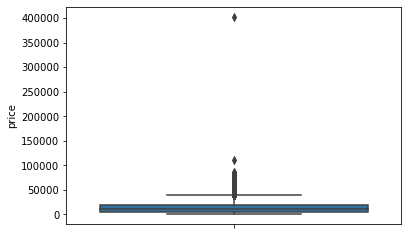

In [29]:
sns.boxplot(y='price', data=df)

In [ ]:
## TODO: visualize categorical vars and PRICE

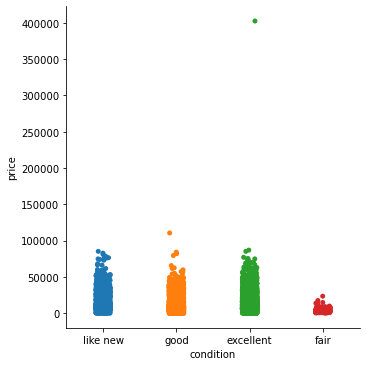

In [32]:
sns.catplot(x='condition', y='price', data=df)

In [ ]:
## TODO: write about trends btwn price and various features (how they correlate as they go up or down)

In [ ]:
## Part 2:
## TODO: Do hyp testing for stat sig of F1 - F4 attributes


# Modeling step
Your Technical Manager said: “I would like you to propose a predictive model, that can be
used to determine price of a used car. The problem is that the state-law demands that this model
be easily interpretable. It means that we are restricted to use simple methods like Linear
Regression, Ridge Regression, LASSO and Elastic Net. Additionally, we need to know how accurate the model is. You must choose the best model and report its root mean square error.
Describe everything in your report and I will study it carefully”.
Hint: In the most typical approach, you need to build three datasets: a training set, a validation set and a test set.
You will use validation set to determine the best model; the test set to estimate model accuracy. In your report you
should describe how you trained the models, how you selected the best one and how you tested its performance at
the end.

In [ ]:
## split in train/test/valid
## spot check models
## try diff models compare results
## evaluate models using diff metrics
## k fold CV

The Senior Developer took you aside and said: “My task is to deploy your model to
production. But I cannot deploy a paper-report. I need your code. However, remember that I am
not a Data Scientist list you. I have a different expertise. I will read your code, but you should
make sure that I can follow and understand it – and that I know how to use it.”
Hint: In the ideal case, people should be able to take your code, run it and recreate all your results. In a less ideal
case, it should be a demonstration of typical run. The code should demonstrate your approach end-to-end. People
should just specify the path to the dataset, run it and see final results. Another name for this is a technical demo. At
your future work, you might be quite often asked to demo your results. People will expect you to present an end-to-
end example where you read the raw data, train your model and evaluate the results of the predictions.